# Proyek Pertama: Model NLP dengan TensorFlow
---
### Nama &emsp;&ensp;&nbsp;: Audric Lysander
### Email  &emsp;&emsp;: audriclysander@gmail.com
### Kelas &emsp;&emsp;: Belajar Pengembangan Machine Learning
### Dataset &emsp;: Emotion Detection from Text

Deteksi emosi dari teks adalah salah satu masalah yang menantang dalam Natural Language Processing. Alasannya adalah tidak tersedianya dataset berlabel dan sifat masalah multi-kelas. Manusia memiliki berbagai emosi dan sulit untuk mengumpulkan catatan yang cukup untuk setiap emosi dan karenanya masalah ketidakseimbangan kelas muncul. Di sini kami memiliki data berlabel untuk deteksi emosi dan tujuannya adalah untuk membangun model yang efisien untuk mendeteksi emosi. [Source](https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text)

## Import Libraries

Melakukan import libraries yang dibutuhkan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

## Load Data

Membaca data csv dan melihat informasi data

In [2]:
df = pd.read_csv('tweet_emotions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [3]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


Menghapus kolom tweet_id karena tidak diperlukan

In [4]:
df = df.drop(columns="tweet_id")
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [5]:
df = df[:3000]
df

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
...,...,...
2995,relief,is gutted to be at work when it is sooo nice o...
2996,happiness,is going back home love ya Zagrebe &lt;3
2997,hate,Geography papers are so boring! I hate revision!
2998,neutral,Came out of my house this morning to the stink...


Melakukan one-hot-encoding pada kolom sentiment

In [6]:
category = pd.get_dummies(df.sentiment)
df_new = pd.concat([df, category], axis=1)
df_new = df_new.drop(columns='sentiment')
df_new['content']=df_new['content'].fillna('').apply(str)
df_new.head()

,content,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
0,@tiffanylue i know i was listenin to bad habi...,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Layin n bed with a headache ughhhh...waitin o...,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Funeral ceremony...gloomy friday...,0,0,0,0,0,0,0,0,0,0,1,0,0
3,wants to hang out with friends SOON!,0,0,0,1,0,0,0,0,0,0,0,0,0
4,@dannycastillo We want to trade with someone w...,0,0,0,0,0,0,0,0,1,0,0,0,0


Mengubah tipe data dataframe menjadi array agar dapat diproses oleh model

In [7]:
text = df_new['content'].values
label = df_new[['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
                'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
                'worry']].values

Menggunakan library NLTK (menghilangkan stopwords dan tanda baca) untuk memproses data text sebelum digunakan untuk melatih model machine learning.

In [8]:
index = 0
while index < len(text):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  new_words = tokenizer.tokenize(str(text[index]))
  new_words = " ".join(new_words)

  stop_words = set(stopwords.words('english'))
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  word_tokens = tokenizer.tokenize(new_words)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  text[index] = " ".join(filtered_sentence)

  index = index+1

Melakukan split untuk data train dan test, dengan data test sebesar 20%

In [9]:
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=0.2)

Melakukan tokenizer

In [10]:
tokenizer = Tokenizer(num_words=5000, oov_token='<oov>')
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_test)
 
sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)
 
padded_train = pad_sequences(y_train) 
padded_test = pad_sequences(y_test)

Melakukan pemodelan machine learning dengan layer embedding

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98 and logs.get('val_accuracy')>0.98):
      print("\nAkurasi telah mencapai > 98%!")
      self.model.stop_training = True
callbacks = myCallback()

In [13]:
num_epochs = 30
history = model.fit(padded_train, y_train, epochs=num_epochs, 
                    validation_data=(padded_test, y_test), verbose=2,
                    callbacks=[callbacks])

Epoch 1/30
75/75 - 7s - loss: 2.1121 - accuracy: 0.2958 - val_loss: 1.8594 - val_accuracy: 0.3283 - 7s/epoch - 89ms/step
Epoch 2/30
75/75 - 1s - loss: 1.8170 - accuracy: 0.3446 - val_loss: 1.3523 - val_accuracy: 0.5750 - 1s/epoch - 17ms/step
Epoch 3/30
75/75 - 1s - loss: 0.8500 - accuracy: 0.7250 - val_loss: 0.3080 - val_accuracy: 0.9267 - 1s/epoch - 18ms/step
Epoch 4/30
75/75 - 1s - loss: 0.1881 - accuracy: 0.9483 - val_loss: 0.0823 - val_accuracy: 0.9800 - 1s/epoch - 18ms/step
Epoch 5/30
75/75 - 1s - loss: 0.0738 - accuracy: 0.9787 - val_loss: 0.0391 - val_accuracy: 0.9900 - 1s/epoch - 17ms/step
Epoch 6/30

Akurasi telah mencapai > 98%!
75/75 - 1s - loss: 0.0314 - accuracy: 0.9892 - val_loss: 0.0176 - val_accuracy: 0.9900 - 1s/epoch - 17ms/step


Membuat visualisasi accuracy dan loss untuk data train dan test

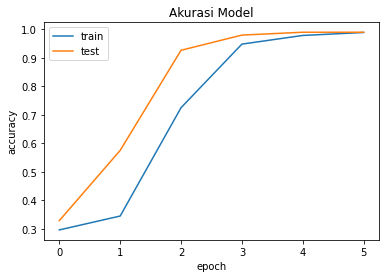

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

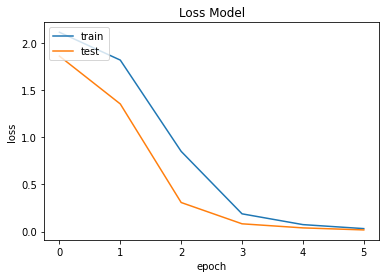

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()